In [3]:
import os
import tifffile as tf 

In [2]:
from matplotlib.pyplot import *

In [6]:
from pathlib import Path

In [20]:
n,z,p,br,bf = [tf.imread(fn) for fn in list(Path(r'D:\2025QPSC\data\189FullImage\ppm_10x_1\121583_48062').rglob('0.tif'))]

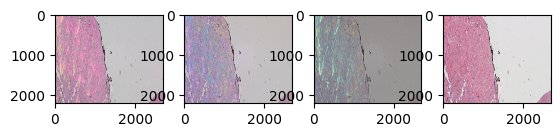

In [25]:
subplot(1,4,1)
imshow(p)
subplot(1,4,2)
imshow(n)
subplot(1,4,3)
imshow(z)
subplot(1,4,4)
imshow(bf)

In [27]:
n.dtype

dtype('uint8')

In [31]:
res = max_hue_difference(n,p)
res.shape

(2200, 2688)

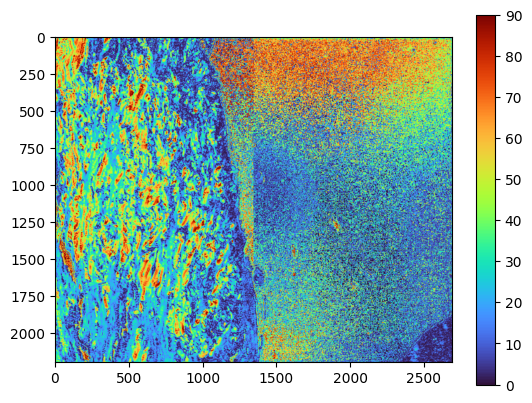

In [34]:
imshow(res,cmap='turbo')
colorbar()

In [30]:
import cv2
import numpy as np

def max_hue_difference(img1, img2):
    """
    Calculate maximum hue difference between two RGB images.
    
    Returns:
        float: Maximum angular difference in degrees (0-180)
    """
    # Convert RGB to HSV
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
    
    # Extract hue channels (0-179 in OpenCV)
    hue1 = hsv1[:, :, 0].astype(np.float32)
    hue2 = hsv2[:, :, 0].astype(np.float32)
    
    # Calculate circular difference
    diff = np.abs(hue1 - hue2)
    diff = np.minimum(diff, 180 - diff)  # Handle wraparound
    
    return diff #np.max(diff) * 2  # Convert to 0-360 degrees

In [37]:
import numpy as np
from skimage.color import rgb2lab, deltaE_ciede2000
import colour

def max_perceptual_difference(img1, img2):
    """
    Calculate maximum perceptual color difference using CIEDE2000.
    More accurate than hue difference.
    """
    lab1 = rgb2lab(img1 / 255.0)
    lab2 = rgb2lab(img2 / 255.0)
    
    # Delta E CIEDE2000 - industry standard
    delta_e = deltaE_ciede2000(lab1, lab2)
    return delta_e #np.max(delta_e)

def max_rgb_euclidean(img1, img2):
    """
    Simple Euclidean distance in RGB space.
    Fast but not perceptually uniform.
    """
    diff = np.linalg.norm(img1 - img2, axis=2)
    return diff #np.max(diff)

# Using colour-science (more advanced)


def max_angle_difference(img1, img2):
    """
    Angular difference in normalized RGB space.
    Treats colors as 3D vectors.
    """
    # Normalize to unit vectors
    v1 = img1.reshape(-1, 3) / 255.0
    v2 = img2.reshape(-1, 3) / 255.0
    
    # Compute angles between color vectors
    dots = np.sum(v1 * v2, axis=1) / (np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1))
    angles = np.arccos(np.clip(dots, -1, 1))
    
    return np.degrees(angles)#np.degrees(np.max(angles))

(5913600,)


TypeError: Invalid shape (5913600,) for image data

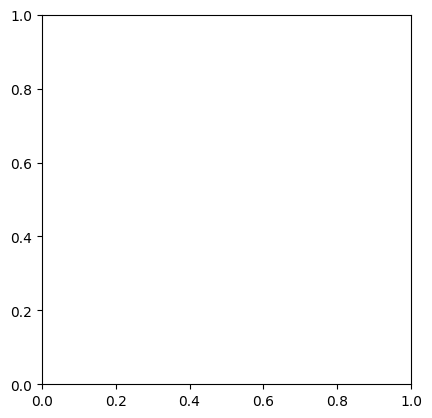

In [38]:
for result in [ max_angle_difference(p,n), 
                max_rgb_euclidean(p,n),
                max_perceptual_difference(p,n)]:
    print(result.shape)
    figure()
    imshow(result)

In [40]:
import numpy as np
import cv2

def ppm_angle_difference(img1, img2):
    """
    Calculate angle difference for polarized microscopy images.
    Color represents retardation angle via interference colors.
    """
    # Convert to float for calculations
    img1_f = img1.astype(np.float32) / 255.0
    img2_f = img2.astype(np.float32) / 255.0
    
    # Method 1: Direct RGB difference (simple but effective)
    rgb_diff = np.sqrt(np.sum((img1_f - img2_f)**2, axis=2))
    
    # Method 2: Hue-based for interference color progression
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
    
    # Hue difference with special handling for Michel-Lévy sequence
    hue_diff = np.abs(hsv1[:,:,0] - hsv2[:,:,0])
    hue_diff = np.minimum(hue_diff, 180 - hue_diff)
    
    # Weight by saturation (gray areas have no birefringence)
    saturation_mask = (hsv1[:,:,1] + hsv2[:,:,1]) / 2.0 / 255.0
    weighted_diff = hue_diff * saturation_mask
    
    return rgb_diff, weighted_diff

def extract_birefringent_regions(img1, img2, threshold=0.1):
    """
    Identify birefringent regions based on angle-dependent color change.
    """
    rgb_diff, weighted_diff = ppm_angle_difference(img1, img2)
    
    # Birefringent regions show high difference
    birefringent_mask = rgb_diff > threshold
    
    # Non-birefringent regions become near-zero
    background_mask = rgb_diff < threshold
    
    return birefringent_mask, rgb_diff

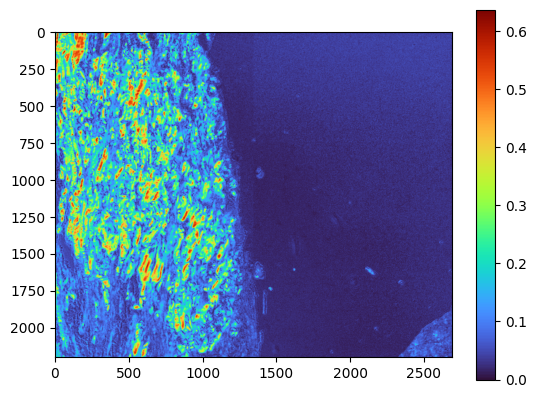

In [52]:
rgb_diff, weighted_diff = ppm_angle_difference(n,p)
imshow(rgb_diff,cmap='turbo')
colorbar()

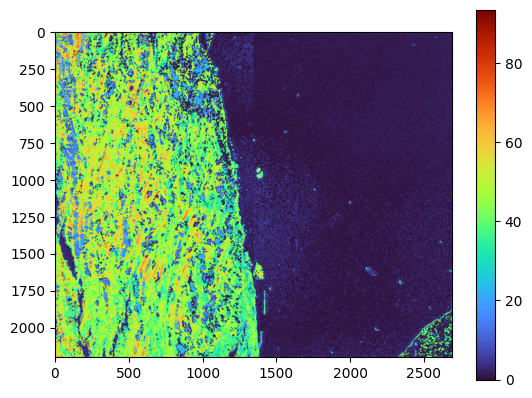

In [55]:
imshow(weighted_diff,cmap='turbo')
colorbar()

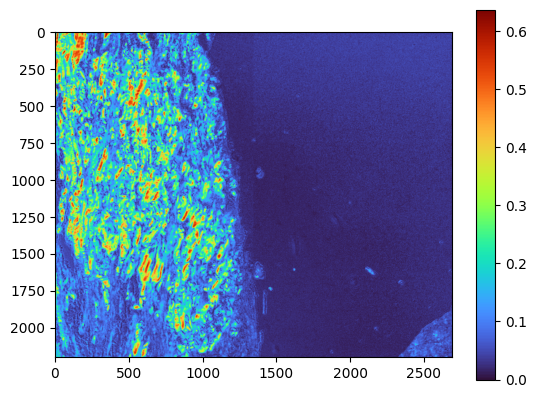

In [50]:
birefringent_mask, rgb_diff_background = extract_birefringent_regions(p,n,0.1)
imshow(rgb_diff,cmap='turbo')
colorbar()